In [ ]:
# Load all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
import time

In [ ]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style("darkgrid")

# Print TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
# Load and clean dataset
dataset_path = "/content/dataset_full.csv"
data = pd.read_csv(dataset_path)
data = data.dropna().drop_duplicates()

In [ ]:
# Convert boolean features to integer
bool_cols = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params',
             'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index',
             'url_shortened', 'phishing']
data[bool_cols] = data[bool_cols].astype(int)

# Identify numerical columns
numerical_cols = [col for col in data.columns if col not in bool_cols]

# Normalize numerical features
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Save preprocessed dataset
data.to_csv("newphishdata.csv", index=False)
print("Data preprocessed and saved.")

Data preprocessed and saved.


<ipython-input-5-150872b5e38a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='phishing', data=data, palette='coolwarm')


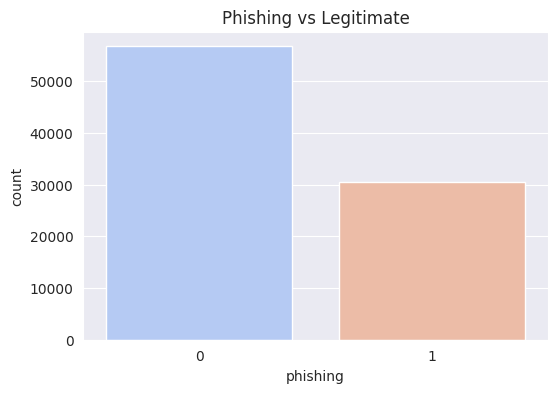

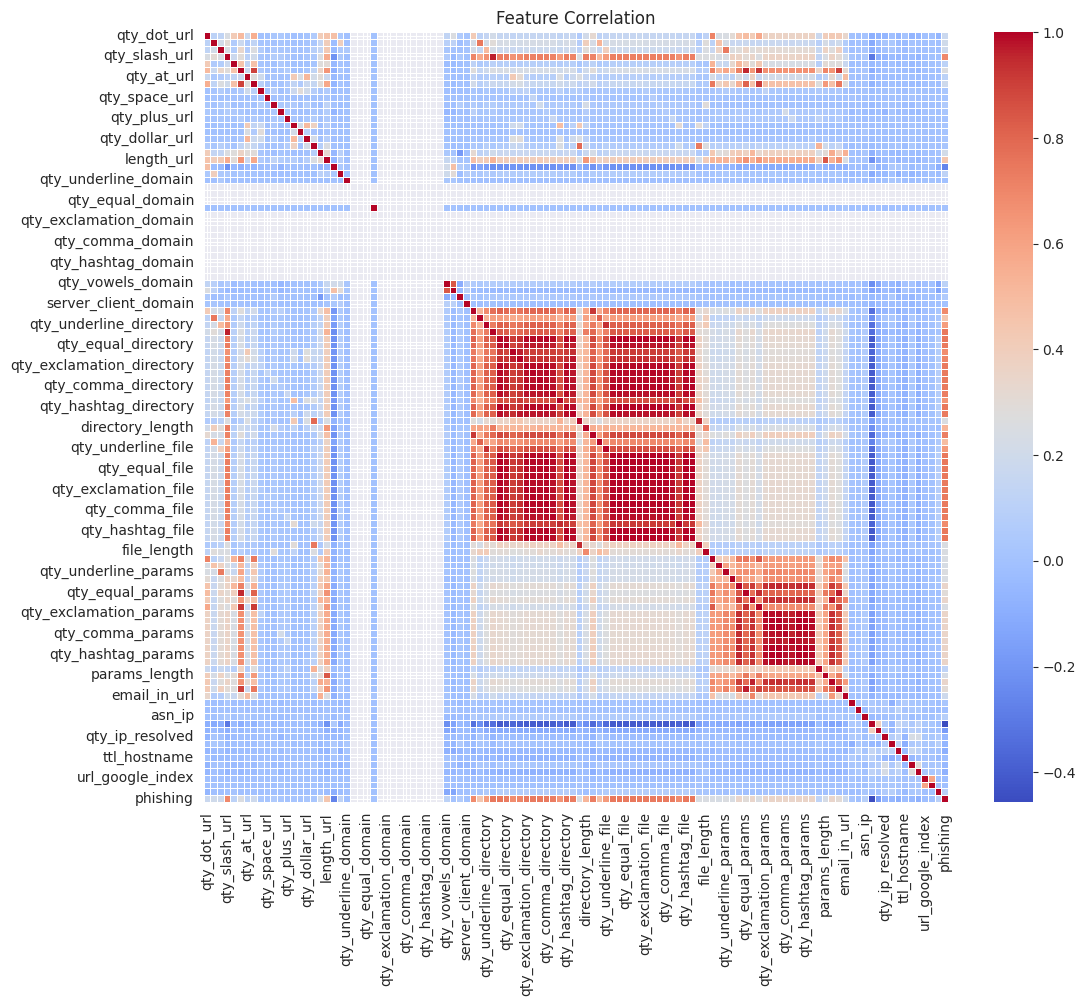

In [ ]:
# Exploratory Data Analysis
plt.figure(figsize=(6, 4))
sns.countplot(x='phishing', data=data, palette='coolwarm')
plt.title("Phishing vs Legitimate")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation")
plt.show()

In [ ]:
# Split dataset
X = data.drop('phishing', axis=1)
y = data['phishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Reshape for CNN/BiLSTM
X_train = np.expand_dims(X_train.values, axis=2)
X_test = np.expand_dims(X_test.values, axis=2)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (69767, 111, 1)
Test shape: (17442, 111, 1)


In [ ]:
# Build CNN + BiLSTM model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Bidirectional(LSTM(32, return_sequences=False)),  # Single LSTM layer
    Dropout(0.1),

    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 109, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,993 (82.00 KB)

 Trainable params: 20,993 (82.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping and timing callbacks
epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    global epoch_start_time
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} time: {epoch_times[-1]:.2f} sec")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)
]

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8523 - auc_1: 0.9119 - loss: 0.3271 - precision_1: 0.7334 - recall_1: 0.9041Epoch 1 time: 111.04 sec
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 111s 48ms/step - accuracy: 0.8523 - auc_1: 0.9119 - loss: 0.3271 - precision_1: 0.7334 - recall_1: 0.9041 - val_accuracy: 0.8987 - val_auc_1: 0.9605 - val_loss: 0.2394 - val_precision_1: 0.8172 - val_recall_1: 0.9149
Epoch 2/50
2180/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8934 - auc_1: 0.9588 - loss: 0.2405 - precision_1: 0.8214 - recall_1: 0.8891Epoch 2 time: 104.38 sec
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 104s 48ms/step - accuracy: 0.8934 - auc_1: 0.9588 - loss: 0.2405 - precision_1: 0.8214 - recall_1: 0.8891 - val_accuracy: 0.9107 - val_auc_1: 0.9724 - val_loss: 0.2031 - val_precision_1: 0.8894 - val_recall_1: 0.8505
Epoch 3/50
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9079 - auc_1: 0.9695 - loss: 0.2101 - precision_1: 0.8513 - recall_1: 0.8942Epoch 3 time: 145.0

In [ ]:
# Predict and evaluate
y_pred = (model.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

Evaluation Metrics:
Accuracy: 0.9537
Precision: 0.9406
Recall: 0.9262
AUC: 0.9474
Confusion Matrix:
[[10986   357]
 [  450  5649]]


In [ ]:
# FAR and FRR
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print(f"False Acceptance Rate (FAR): {far:.4f}")
print(f"False Rejection Rate (FRR): {frr:.4f}")
print(f"Avg Epoch Time: {np.mean(epoch_times):.2f} sec")

False Acceptance Rate (FAR): 0.0315
False Rejection Rate (FRR): 0.0738
Avg Epoch Time: 133.22 sec


In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x500 with 0 Axes>